In [10]:
# ha senso analizzare un solo giocatore e addestrare con i suoi dati?
#come scegliere p e q guardando i grafici di autocorrelazione parziale e non
#true e false nel predict

In [11]:
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install statsmodels
%pip install datetime


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import os as os
from datetime import datetime

In [13]:
percorso_csv = r"../../csv_post_etl"
 
df_appearances = pd.read_csv(percorso_csv + "/appearances_post.csv")
df_club_games = pd.read_csv(percorso_csv + "/club_games_post.csv")
df_clubs = pd.read_csv(percorso_csv + "/clubs_post.csv")
df_competitions = pd.read_csv(percorso_csv + "/competitions_post.csv")
df_game_events = pd.read_csv(percorso_csv + "/game_events_post.csv")
df_game_lineups = pd.read_csv(percorso_csv + "/game_lineups_post.csv")
df_games = pd.read_csv(percorso_csv + "/games_post.csv")
df_player_valuations = pd.read_csv(percorso_csv + "/player_valuations_post.csv")
df_players = pd.read_csv(percorso_csv + "/players_post.csv")

In [14]:
df_per_previsione = df_player_valuations[["date", "market_value_in_eur", "player_id"]]
df_per_previsione["date"] = pd.to_datetime(df_per_previsione["date"])

# Trova i giocatori che hanno almeno una data nel 2023
players_with_2023_dates = df_per_previsione[df_per_previsione['date'].dt.year == 2023]['player_id'].unique()

# Filtra il DataFrame originale per i giocatori trovati
df_per_previsione = df_per_previsione[df_per_previsione['player_id'].isin(players_with_2023_dates)]

# Stampa il DataFrame risultante
#print(df_per_previsione)

C:\Users\mikdr\AppData\Local\Temp\ipykernel_19872\2884229399.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_per_previsione["date"] = pd.to_datetime(df_per_previsione["date"])


In [15]:
#pd.set_option('display.max_row', None)
df_per_previsione['date'] = df_per_previsione['date'].dt.to_period('M').dt.to_timestamp()
df_per_previsione["date"] = pd.to_datetime(df_per_previsione["date"])

#Espandi il DataFrame
expanded_data = []

#Raggruppa per player_id
for player_id, group in df_per_previsione.groupby('player_id'):
    player_data = group.sort_values('date')
    
    #Crea un DataFrame con tutte le date del mese e giorno 1
    all_dates = pd.date_range(player_data['date'].min(), player_data['date'].max(), freq='MS')
    all_dates_df = pd.DataFrame({'date': all_dates})
    
    # Unisci il DataFrame con tutte le date con i dati esistenti
    player_data_expanded = pd.merge(all_dates_df, player_data, on='date', how='left')
    
    # Riempie le date mancanti con i valori precedenti/futuri già esistenti
    player_data_expanded['market_value_in_eur'] = player_data_expanded['market_value_in_eur'].ffill().bfill()
    player_data_expanded['player_id'] = player_data_expanded['player_id'].ffill().bfill()

    expanded_data.append(player_data_expanded)

# Concatena tutti i DataFrame espansi
df_expanded = pd.concat(expanded_data, ignore_index=True)

In [16]:
df_expanded["player_id"] = df_expanded["player_id"].astype(int)
df_expanded = df_expanded.set_index('date')

In [18]:
df_expanded.to_csv('../../csv_post_etl/serie_temp_post.csv', index=False)

In [19]:
df_previsione_post_etl = pd.read_csv(percorso_csv + "/serie_temp_post.csv")

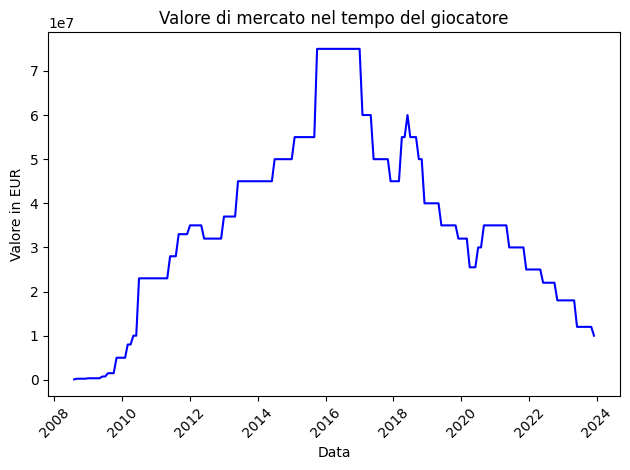

In [20]:
# Specifica il player_id del giocatore di interesse
player_id_to_plot = 58358  # Cambia questo valore con l'id del giocatore desiderato

# Filtra il DataFrame per il giocatore specifico
player_data_to_plot = df_expanded[df_expanded["player_id"] == player_id_to_plot]
#print(player_data_to_plot)

# Crea il plot mondiale supremo
plt.plot(player_data_to_plot.index, player_data_to_plot["market_value_in_eur"], linestyle='-', color='b')

# Personalizza il plot
plt.title(f'Valore di mercato nel tempo del giocatore')
plt.xlabel('Data')
plt.ylabel('Valore in EUR')
plt.xticks(rotation=45)  # Rotazione delle etichette sull'asse x per migliorare la leggibilità

# Mostra il plot
plt.tight_layout()
plt.savefig(f"../../images/serie_temp_id_{player_id_to_plot}.png")
plt.show()

C:\Users\mikdr\AppData\Local\Temp\ipykernel_19872\2171231374.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  differenced_series['lag'] = differenced_series['market_value_in_eur'].shift(1)


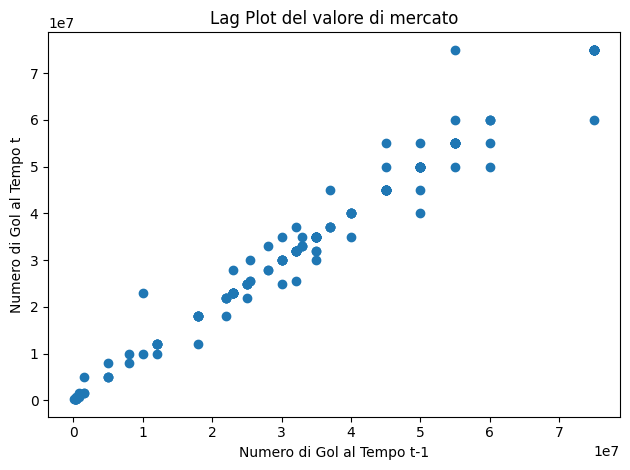

In [21]:
differenced_series = player_data_to_plot
# Aggiungi colonne con i valori ritardati (lag) al dataframe
differenced_series['lag'] = differenced_series['market_value_in_eur'].shift(1)

# Rimuovi le prime righe che avranno valori NaN a causa dello shift
differenced_series = differenced_series.dropna()

plt.scatter(differenced_series['lag'], differenced_series['market_value_in_eur'])

# Personalizza il plot
plt.title('Lag Plot del valore di mercato')
plt.xlabel('Numero di Gol al Tempo t-1')
plt.ylabel('Numero di Gol al Tempo t')

# Mostra il plot
plt.tight_layout()
plt.savefig(f"../../images/lag_plot_serie_temp_id_{player_id_to_plot}.png")

# Mostra il plot
plt.show()

In [22]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(ts):
    stats = ['Test Statistic','p-value','Lags','Observations']
    df_test = adfuller(ts, autolag='AIC')
    df_results = pd.Series(df_test[0:4], index=stats)
    for key,value in df_test[4].items():
        df_results['Critical Value (%s)'%key] = value
    print(df_results)

In [23]:
differenced_series = player_data_to_plot

In [24]:
test_stationarity(differenced_series['market_value_in_eur'])

Test Statistic           -1.400888
p-value                   0.581851
Lags                      0.000000
Observations            184.000000
Critical Value (1%)      -3.466398
Critical Value (5%)      -2.877380
Critical Value (10%)     -2.575214
dtype: float64


In [25]:
# Esegui la differenziazione della serie temporale
differenced_series["diff"] = differenced_series['market_value_in_eur'].diff()

# Esegui nuovamente il test di stazionarietà sulla serie differenziata
test_stationarity(differenced_series["diff"].dropna())

Test Statistic         -1.364635e+01
p-value                 1.616843e-25
Lags                    0.000000e+00
Observations            1.830000e+02
Critical Value (1%)    -3.466598e+00
Critical Value (5%)    -2.877467e+00
Critical Value (10%)   -2.575260e+00
dtype: float64


C:\Users\mikdr\AppData\Local\Temp\ipykernel_19872\1943802469.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  differenced_series["diff"] = differenced_series['market_value_in_eur'].diff()


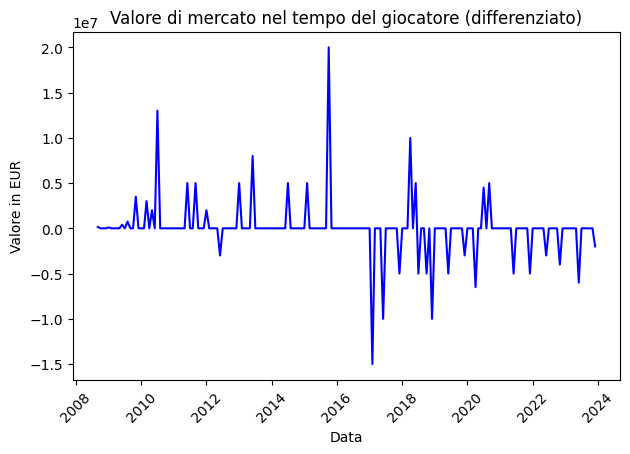

In [26]:
plt.plot(differenced_series.index, differenced_series["diff"], linestyle='-', color='b')

# Personalizza il plot
plt.title(f'Valore di mercato nel tempo del giocatore (differenziato)')
plt.xlabel('Data')
plt.ylabel('Valore in EUR')
plt.xticks(rotation=45)  # Rotazione delle etichette sull'asse x per migliorare la leggibilità

# Mostra il plot
plt.tight_layout()
plt.savefig(f"../../images/serie_temp_diff_id_{player_id_to_plot}.png")
plt.show()

date
2008-08-01          NaN
2008-09-01     150000.0
2008-10-01          0.0
2008-11-01          0.0
2008-12-01          0.0
                ...    
2023-08-01          0.0
2023-09-01          0.0
2023-10-01          0.0
2023-11-01          0.0
2023-12-01   -2000000.0
Name: diff, Length: 185, dtype: float64


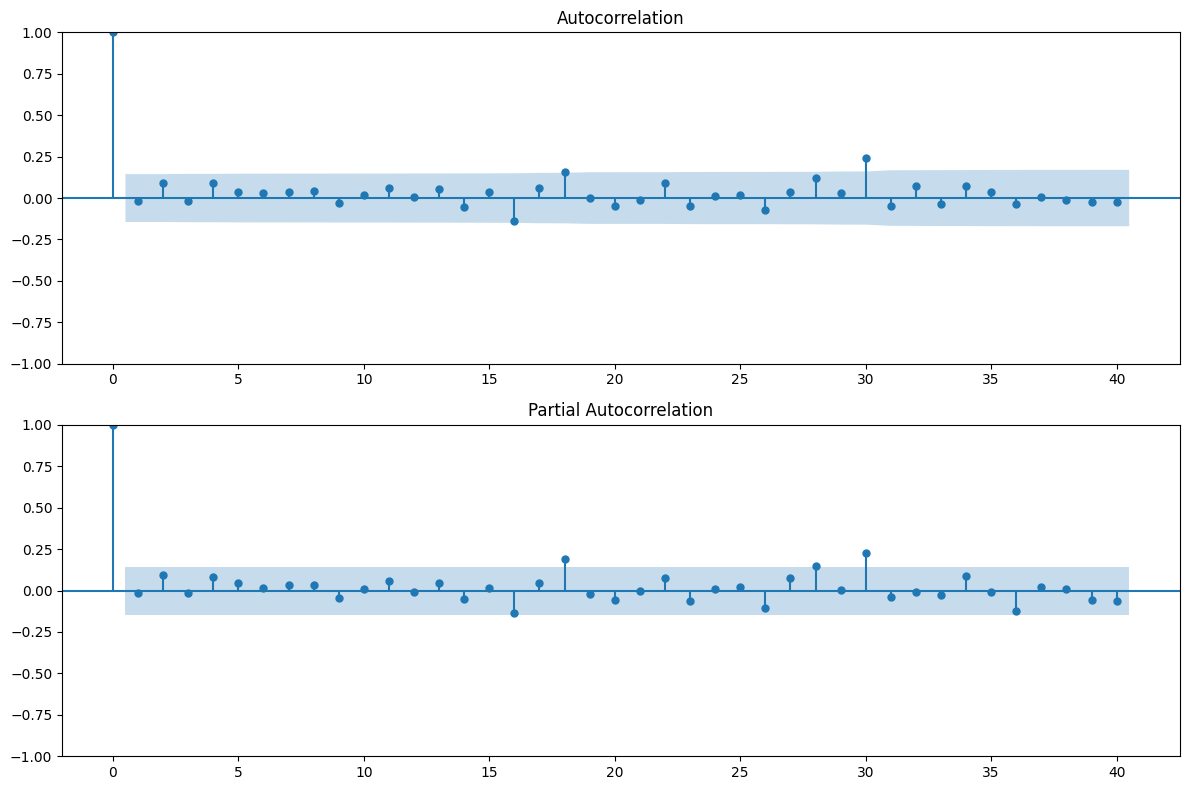

In [27]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
print(differenced_series["diff"])
fig = sm.graphics.tsa.plot_acf(differenced_series["diff"][1:], lags=40, ax=ax1)   # first value of diff is NaN
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(differenced_series["diff"][1:], lags=40, ax=ax2)

plt.tight_layout()
plt.savefig(f"../../images/ac_pac_player_{player_id_to_plot}.png")

c:\Users\mikdr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\mikdr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\mikdr\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                SARIMAX Results                                
Dep. Variable:     market_value_in_eur   No. Observations:                  185
Model:                  ARIMA(0, 1, 0)   Log Likelihood               -3005.424
Date:                 Sat, 13 Jan 2024   AIC                           6012.847
Time:                         10:43:49   BIC                           6016.062
Sample:                     08-01-2008   HQIC                          6014.150
                          - 12-01-2023                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.965e+12   3.09e+11     29.020      0.000    8.36e+12    9.57e+12
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              2012.53
Prob(Q):                              0

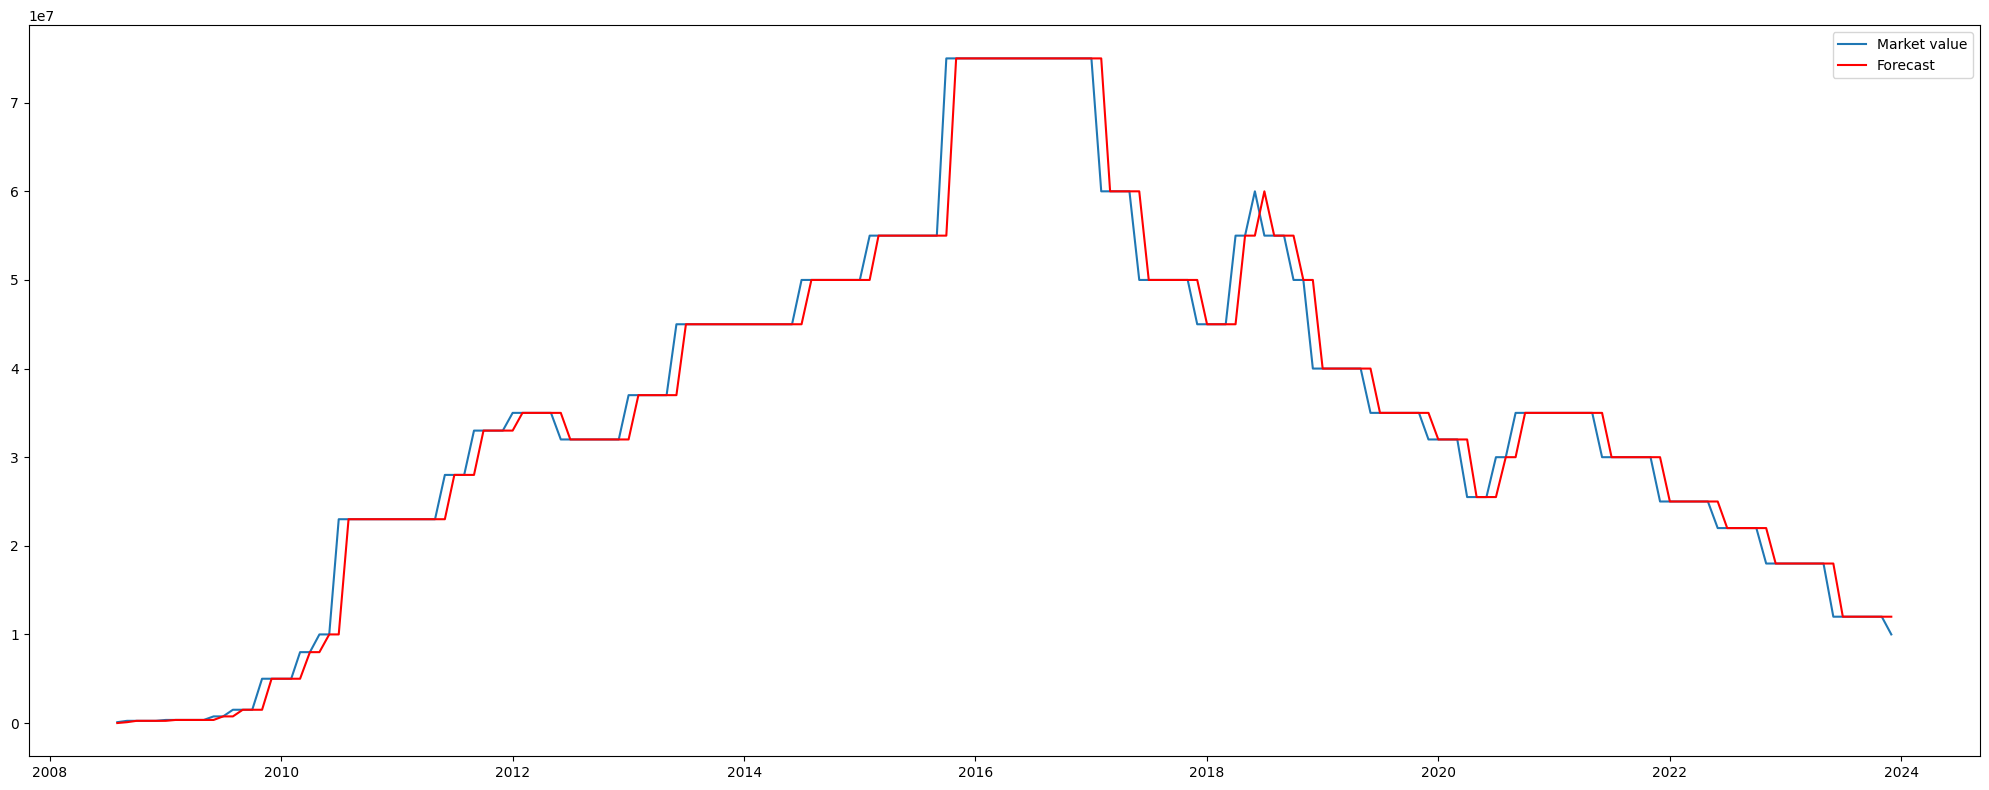

In [28]:
# fit ARIMA model
fig = plt.figure(figsize=(20,8))
model = ARIMA(differenced_series["market_value_in_eur"], order=(0,1,0)) 
ax = plt.gca()
results = model.fit()
plt.plot(differenced_series["market_value_in_eur"])
plt.plot(results.fittedvalues, color='red')
ax.legend(['Market value', 'Forecast'])
plt.tight_layout()
plt.savefig(f"../../images/model_ARIMA_player_{player_id_to_plot}.png")

print(results.summary())

In [29]:
numero_righe = len(differenced_series)
print(numero_righe)

185


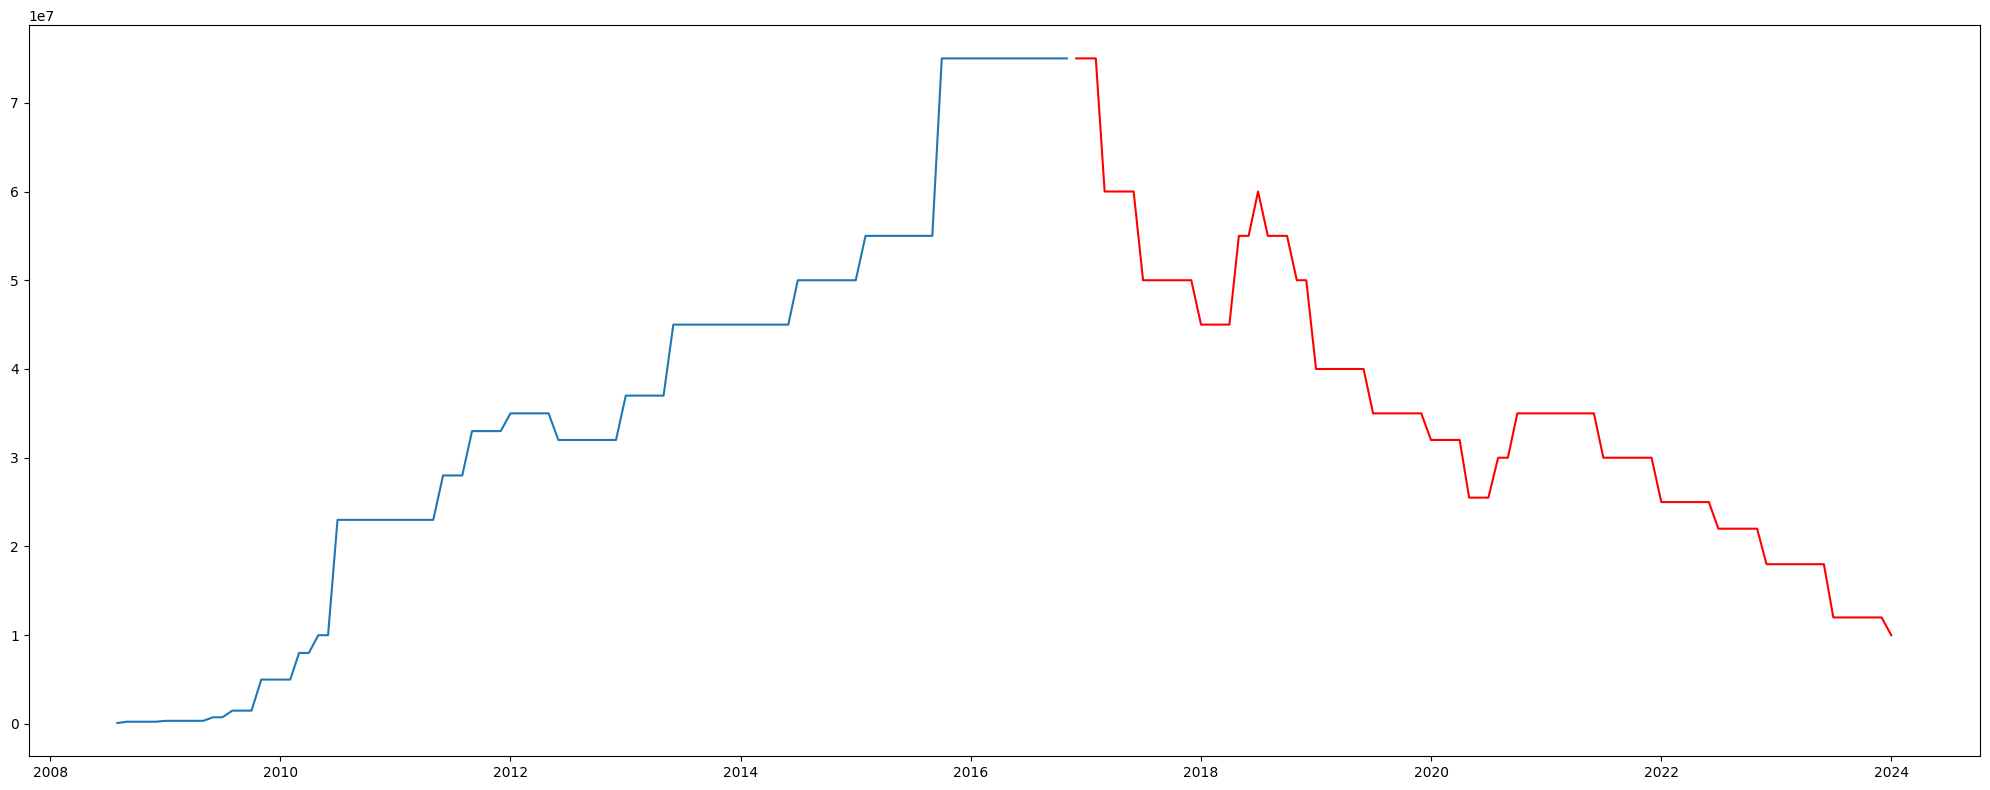

In [30]:
fig = plt.figure(figsize=(20,8))
num_points = len(differenced_series['market_value_in_eur'])
x = results.predict(start=(100), end=(185), dynamic=False)
plt.plot(differenced_series['market_value_in_eur'][:100])
plt.plot(x, color='r')
plt.tight_layout()
plt.savefig(f"../../images/prediction_ARIMA_player_{player_id_to_plot}.png")